# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

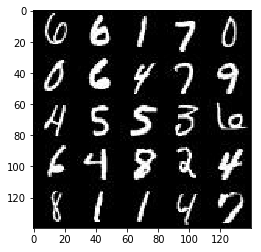

In [2]:
show_n_images = 30

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

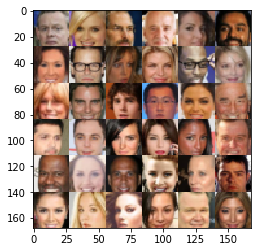

In [12]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [14]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_r = tf.placeholder(tf.float32, shape=[None,image_height, image_width, image_channels], name='inputs_r')
    inputs_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='inputs_z')
    lrate = tf.placeholder(tf.float32, name='lrate')
    return (inputs_r, inputs_z, lrate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [15]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        
        l1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='SAME')
        lrelu1 = tf.maximum(0.01 * l1, l1)
        
        l2 = tf.layers.conv2d(lrelu1, 256, 5, strides=2, padding='SAME')
        bnorm2 = tf.layers.batch_normalization(l2, training=True)
        lrelu2 = tf.maximum(0.01 * bnorm2, bnorm2)
        
        l3 = tf.layers.conv2d(lrelu2, 512, 5, strides=2, padding='SAME')
        bnorm3 = tf.layers.batch_normalization(l3, training=True)
        lrelu3 = tf.maximum(0.01 * bnorm3, bnorm3)
        
        flatten = tf.reshape(lrelu3, [-1, 4*4*512])
        
        logits = tf.layers.dense(flatten, 1, activation=None)
        out = tf.sigmoid(logits)
    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse = not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
       
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
       
        
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        
        
        
        out = tf.tanh(logits)
        
  
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies(update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    steps = 0
    total_steps = epoch_count * batch_size
    losses = []
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(
                    disc_opt, 
                    feed_dict={
                        input_real: batch_images, input_z: batch_z, lr: learning_rate 
                    }
                )
                _ = sess.run(
                    gen_opt, 
                    feed_dict={
                        input_real: batch_images, 
                        input_z: batch_z, 
                        lr:learning_rate
                    }
                )
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    # show samples
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    

        saver.save(sess, './generator.ckpt')
                
    return losses
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


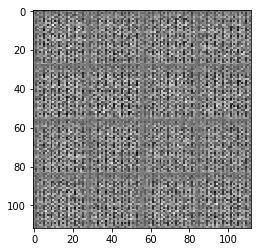

Epoch 1/2... Discriminator Loss: 0.8444... Generator Loss: 20.0726
Epoch 1/2... Discriminator Loss: 2.6061... Generator Loss: 0.1362
Epoch 1/2... Discriminator Loss: 1.0352... Generator Loss: 3.1590
Epoch 1/2... Discriminator Loss: 1.6670... Generator Loss: 2.9360
Epoch 1/2... Discriminator Loss: 2.8505... Generator Loss: 0.1358
Epoch 1/2... Discriminator Loss: 1.2372... Generator Loss: 0.7883
Epoch 1/2... Discriminator Loss: 1.1887... Generator Loss: 1.1030
Epoch 1/2... Discriminator Loss: 1.3985... Generator Loss: 0.5169
Epoch 1/2... Discriminator Loss: 1.7236... Generator Loss: 0.3694
Epoch 1/2... Discriminator Loss: 1.5982... Generator Loss: 3.0159


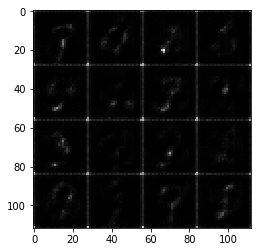

Epoch 1/2... Discriminator Loss: 1.2361... Generator Loss: 0.6134
Epoch 1/2... Discriminator Loss: 0.9301... Generator Loss: 1.0836
Epoch 1/2... Discriminator Loss: 0.9463... Generator Loss: 1.0706
Epoch 1/2... Discriminator Loss: 1.3325... Generator Loss: 0.6538
Epoch 1/2... Discriminator Loss: 0.8867... Generator Loss: 1.4689
Epoch 1/2... Discriminator Loss: 0.9115... Generator Loss: 1.0740
Epoch 1/2... Discriminator Loss: 1.4987... Generator Loss: 0.5033
Epoch 1/2... Discriminator Loss: 0.8676... Generator Loss: 1.3701
Epoch 1/2... Discriminator Loss: 0.8215... Generator Loss: 1.2355
Epoch 1/2... Discriminator Loss: 1.1138... Generator Loss: 1.5147


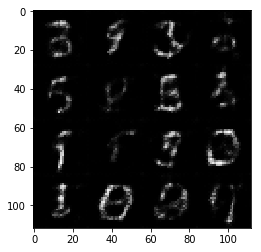

Epoch 1/2... Discriminator Loss: 2.0248... Generator Loss: 0.2838
Epoch 1/2... Discriminator Loss: 1.9768... Generator Loss: 0.3438
Epoch 1/2... Discriminator Loss: 1.0683... Generator Loss: 2.3337
Epoch 1/2... Discriminator Loss: 1.4230... Generator Loss: 0.6274
Epoch 1/2... Discriminator Loss: 1.4365... Generator Loss: 0.4847
Epoch 1/2... Discriminator Loss: 1.0352... Generator Loss: 0.9046
Epoch 1/2... Discriminator Loss: 1.4985... Generator Loss: 0.4402
Epoch 1/2... Discriminator Loss: 0.8287... Generator Loss: 1.6375
Epoch 1/2... Discriminator Loss: 1.0460... Generator Loss: 0.9017
Epoch 1/2... Discriminator Loss: 1.2587... Generator Loss: 0.8253


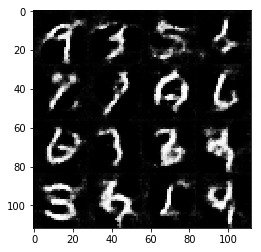

Epoch 1/2... Discriminator Loss: 1.4572... Generator Loss: 0.5202
Epoch 1/2... Discriminator Loss: 1.1370... Generator Loss: 0.7597
Epoch 1/2... Discriminator Loss: 0.9493... Generator Loss: 1.1216
Epoch 1/2... Discriminator Loss: 1.6232... Generator Loss: 0.4770
Epoch 1/2... Discriminator Loss: 0.9444... Generator Loss: 1.2327
Epoch 1/2... Discriminator Loss: 1.0895... Generator Loss: 0.8155
Epoch 1/2... Discriminator Loss: 0.9505... Generator Loss: 1.3166
Epoch 1/2... Discriminator Loss: 1.4851... Generator Loss: 0.4935
Epoch 1/2... Discriminator Loss: 1.2569... Generator Loss: 0.6783
Epoch 1/2... Discriminator Loss: 0.9770... Generator Loss: 1.1474


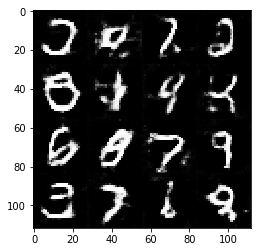

Epoch 1/2... Discriminator Loss: 0.8224... Generator Loss: 1.5944
Epoch 1/2... Discriminator Loss: 0.9664... Generator Loss: 1.7985
Epoch 1/2... Discriminator Loss: 1.2815... Generator Loss: 0.6455
Epoch 1/2... Discriminator Loss: 0.8978... Generator Loss: 1.7529
Epoch 1/2... Discriminator Loss: 0.8480... Generator Loss: 2.0805
Epoch 1/2... Discriminator Loss: 1.0760... Generator Loss: 0.8520
Epoch 1/2... Discriminator Loss: 0.8245... Generator Loss: 1.6268
Epoch 1/2... Discriminator Loss: 1.3914... Generator Loss: 0.5959
Epoch 1/2... Discriminator Loss: 2.0488... Generator Loss: 0.3384
Epoch 1/2... Discriminator Loss: 0.9105... Generator Loss: 1.2236


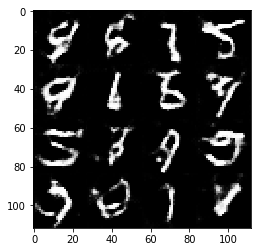

Epoch 1/2... Discriminator Loss: 0.7778... Generator Loss: 1.4029
Epoch 1/2... Discriminator Loss: 0.9864... Generator Loss: 1.2125
Epoch 1/2... Discriminator Loss: 0.9426... Generator Loss: 1.0196
Epoch 1/2... Discriminator Loss: 0.7793... Generator Loss: 1.6336
Epoch 1/2... Discriminator Loss: 0.9846... Generator Loss: 0.9376
Epoch 1/2... Discriminator Loss: 0.8327... Generator Loss: 1.1747
Epoch 1/2... Discriminator Loss: 1.2721... Generator Loss: 0.7420
Epoch 1/2... Discriminator Loss: 1.4290... Generator Loss: 0.5148
Epoch 1/2... Discriminator Loss: 0.7670... Generator Loss: 1.5497
Epoch 1/2... Discriminator Loss: 0.7296... Generator Loss: 1.8530


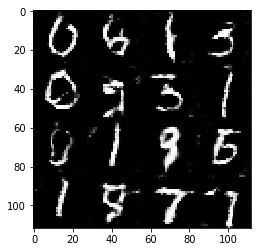

Epoch 1/2... Discriminator Loss: 0.8515... Generator Loss: 1.3866
Epoch 1/2... Discriminator Loss: 0.9001... Generator Loss: 1.4646
Epoch 1/2... Discriminator Loss: 1.1606... Generator Loss: 0.7246
Epoch 1/2... Discriminator Loss: 1.6186... Generator Loss: 0.4889
Epoch 1/2... Discriminator Loss: 0.7250... Generator Loss: 1.8593
Epoch 1/2... Discriminator Loss: 1.3033... Generator Loss: 0.7158
Epoch 1/2... Discriminator Loss: 0.8249... Generator Loss: 1.4768
Epoch 1/2... Discriminator Loss: 1.5815... Generator Loss: 0.4737
Epoch 1/2... Discriminator Loss: 2.0736... Generator Loss: 0.3116
Epoch 1/2... Discriminator Loss: 1.0710... Generator Loss: 0.9263


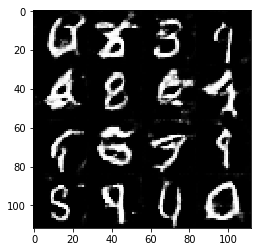

Epoch 1/2... Discriminator Loss: 0.7784... Generator Loss: 1.5532
Epoch 1/2... Discriminator Loss: 1.0877... Generator Loss: 2.5855
Epoch 1/2... Discriminator Loss: 0.9544... Generator Loss: 2.1346
Epoch 1/2... Discriminator Loss: 0.9650... Generator Loss: 0.9424
Epoch 1/2... Discriminator Loss: 0.8537... Generator Loss: 1.5126
Epoch 1/2... Discriminator Loss: 0.6882... Generator Loss: 1.7182
Epoch 1/2... Discriminator Loss: 0.8450... Generator Loss: 1.2141
Epoch 1/2... Discriminator Loss: 1.1612... Generator Loss: 0.7965
Epoch 1/2... Discriminator Loss: 1.4988... Generator Loss: 0.5431
Epoch 1/2... Discriminator Loss: 2.1754... Generator Loss: 0.3100


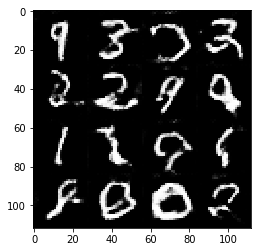

Epoch 1/2... Discriminator Loss: 1.2223... Generator Loss: 0.6638
Epoch 1/2... Discriminator Loss: 1.5052... Generator Loss: 0.6110
Epoch 1/2... Discriminator Loss: 0.7373... Generator Loss: 1.6173
Epoch 1/2... Discriminator Loss: 0.7258... Generator Loss: 1.8469
Epoch 1/2... Discriminator Loss: 0.6713... Generator Loss: 2.4342
Epoch 1/2... Discriminator Loss: 1.0341... Generator Loss: 2.9048
Epoch 1/2... Discriminator Loss: 0.8751... Generator Loss: 2.2508
Epoch 1/2... Discriminator Loss: 1.1035... Generator Loss: 0.8561
Epoch 1/2... Discriminator Loss: 0.9211... Generator Loss: 1.0696
Epoch 1/2... Discriminator Loss: 0.7796... Generator Loss: 1.4245


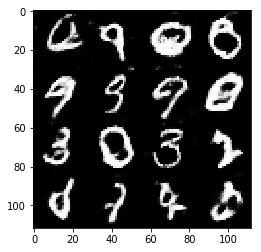

Epoch 1/2... Discriminator Loss: 1.3517... Generator Loss: 0.5982
Epoch 1/2... Discriminator Loss: 0.7175... Generator Loss: 1.5115
Epoch 1/2... Discriminator Loss: 2.0173... Generator Loss: 0.3735
Epoch 2/2... Discriminator Loss: 0.9446... Generator Loss: 1.0995
Epoch 2/2... Discriminator Loss: 0.8797... Generator Loss: 1.3460
Epoch 2/2... Discriminator Loss: 1.3494... Generator Loss: 0.6708
Epoch 2/2... Discriminator Loss: 1.2324... Generator Loss: 0.7427
Epoch 2/2... Discriminator Loss: 1.0769... Generator Loss: 0.8451
Epoch 2/2... Discriminator Loss: 0.8821... Generator Loss: 1.1986
Epoch 2/2... Discriminator Loss: 0.8353... Generator Loss: 2.1067


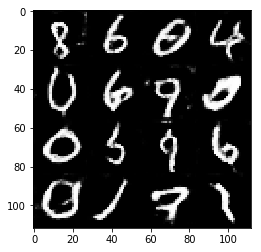

Epoch 2/2... Discriminator Loss: 0.8353... Generator Loss: 2.0091
Epoch 2/2... Discriminator Loss: 0.9368... Generator Loss: 1.2275
Epoch 2/2... Discriminator Loss: 0.9371... Generator Loss: 1.0967
Epoch 2/2... Discriminator Loss: 1.0663... Generator Loss: 0.8529
Epoch 2/2... Discriminator Loss: 0.8666... Generator Loss: 1.1356
Epoch 2/2... Discriminator Loss: 0.7370... Generator Loss: 1.5184
Epoch 2/2... Discriminator Loss: 1.2298... Generator Loss: 0.7928
Epoch 2/2... Discriminator Loss: 0.9726... Generator Loss: 1.2126
Epoch 2/2... Discriminator Loss: 1.2708... Generator Loss: 0.6521
Epoch 2/2... Discriminator Loss: 0.9886... Generator Loss: 0.9439


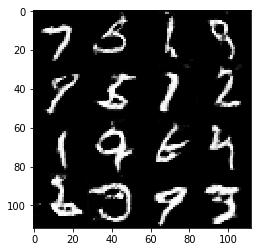

Epoch 2/2... Discriminator Loss: 0.9405... Generator Loss: 1.0189
Epoch 2/2... Discriminator Loss: 0.7239... Generator Loss: 1.8551
Epoch 2/2... Discriminator Loss: 0.7679... Generator Loss: 1.5193
Epoch 2/2... Discriminator Loss: 1.2362... Generator Loss: 0.7009
Epoch 2/2... Discriminator Loss: 1.1122... Generator Loss: 1.7564
Epoch 2/2... Discriminator Loss: 1.5343... Generator Loss: 0.5675
Epoch 2/2... Discriminator Loss: 0.7687... Generator Loss: 2.2399
Epoch 2/2... Discriminator Loss: 1.0348... Generator Loss: 0.9133
Epoch 2/2... Discriminator Loss: 1.2832... Generator Loss: 0.6443
Epoch 2/2... Discriminator Loss: 1.1578... Generator Loss: 0.8496


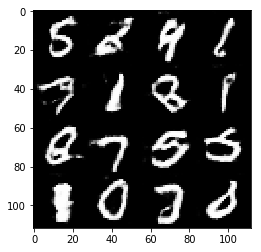

Epoch 2/2... Discriminator Loss: 0.9169... Generator Loss: 1.2599
Epoch 2/2... Discriminator Loss: 0.7489... Generator Loss: 1.9420
Epoch 2/2... Discriminator Loss: 2.7261... Generator Loss: 4.6326
Epoch 2/2... Discriminator Loss: 0.8446... Generator Loss: 1.0559
Epoch 2/2... Discriminator Loss: 1.0088... Generator Loss: 1.0036
Epoch 2/2... Discriminator Loss: 1.2329... Generator Loss: 0.6408
Epoch 2/2... Discriminator Loss: 1.0099... Generator Loss: 0.8952
Epoch 2/2... Discriminator Loss: 1.1946... Generator Loss: 0.7112
Epoch 2/2... Discriminator Loss: 0.7889... Generator Loss: 1.5272
Epoch 2/2... Discriminator Loss: 0.9474... Generator Loss: 1.0402


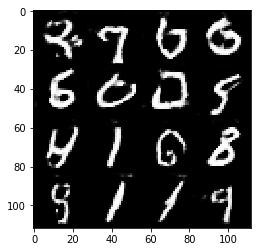

Epoch 2/2... Discriminator Loss: 1.1382... Generator Loss: 0.7906
Epoch 2/2... Discriminator Loss: 1.7453... Generator Loss: 0.3800
Epoch 2/2... Discriminator Loss: 0.8455... Generator Loss: 2.6084
Epoch 2/2... Discriminator Loss: 0.8167... Generator Loss: 1.4713
Epoch 2/2... Discriminator Loss: 1.2302... Generator Loss: 0.7187
Epoch 2/2... Discriminator Loss: 0.7328... Generator Loss: 1.5218
Epoch 2/2... Discriminator Loss: 1.2236... Generator Loss: 0.7659
Epoch 2/2... Discriminator Loss: 0.8053... Generator Loss: 1.6815
Epoch 2/2... Discriminator Loss: 0.6445... Generator Loss: 1.6840
Epoch 2/2... Discriminator Loss: 1.0063... Generator Loss: 1.6433


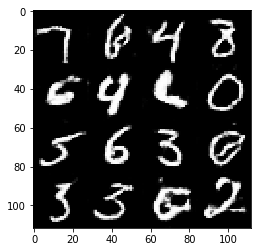

Epoch 2/2... Discriminator Loss: 1.4876... Generator Loss: 0.5476
Epoch 2/2... Discriminator Loss: 1.0487... Generator Loss: 0.9203
Epoch 2/2... Discriminator Loss: 0.6993... Generator Loss: 1.7478
Epoch 2/2... Discriminator Loss: 0.9454... Generator Loss: 1.3155
Epoch 2/2... Discriminator Loss: 0.9226... Generator Loss: 1.1493
Epoch 2/2... Discriminator Loss: 0.7821... Generator Loss: 1.3635
Epoch 2/2... Discriminator Loss: 1.0317... Generator Loss: 0.9272
Epoch 2/2... Discriminator Loss: 0.8847... Generator Loss: 1.1988
Epoch 2/2... Discriminator Loss: 1.3105... Generator Loss: 2.8228
Epoch 2/2... Discriminator Loss: 0.6791... Generator Loss: 1.7579


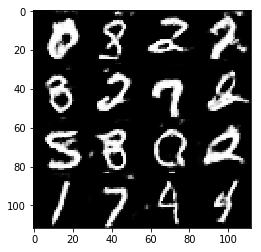

Epoch 2/2... Discriminator Loss: 0.8575... Generator Loss: 1.1564
Epoch 2/2... Discriminator Loss: 1.1267... Generator Loss: 0.8856
Epoch 2/2... Discriminator Loss: 0.9423... Generator Loss: 1.1095
Epoch 2/2... Discriminator Loss: 0.8033... Generator Loss: 1.7925
Epoch 2/2... Discriminator Loss: 0.7329... Generator Loss: 1.4682
Epoch 2/2... Discriminator Loss: 0.9856... Generator Loss: 0.9241
Epoch 2/2... Discriminator Loss: 0.9456... Generator Loss: 1.1035
Epoch 2/2... Discriminator Loss: 1.7736... Generator Loss: 0.4370
Epoch 2/2... Discriminator Loss: 0.9277... Generator Loss: 0.9629
Epoch 2/2... Discriminator Loss: 1.5555... Generator Loss: 0.6018


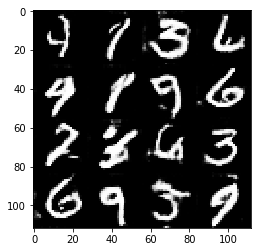

Epoch 2/2... Discriminator Loss: 0.7359... Generator Loss: 1.6750
Epoch 2/2... Discriminator Loss: 0.7102... Generator Loss: 1.5346
Epoch 2/2... Discriminator Loss: 0.6243... Generator Loss: 1.8489
Epoch 2/2... Discriminator Loss: 1.1421... Generator Loss: 0.7654
Epoch 2/2... Discriminator Loss: 0.7205... Generator Loss: 1.4905
Epoch 2/2... Discriminator Loss: 0.9574... Generator Loss: 0.9688
Epoch 2/2... Discriminator Loss: 0.6970... Generator Loss: 1.5305
Epoch 2/2... Discriminator Loss: 0.8549... Generator Loss: 1.1726
Epoch 2/2... Discriminator Loss: 0.6378... Generator Loss: 1.7368
Epoch 2/2... Discriminator Loss: 0.7449... Generator Loss: 1.4560


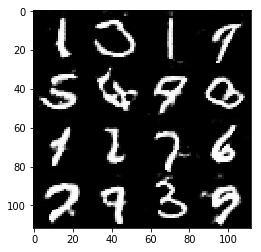

Epoch 2/2... Discriminator Loss: 1.7309... Generator Loss: 0.5653
Epoch 2/2... Discriminator Loss: 0.7005... Generator Loss: 1.5180
Epoch 2/2... Discriminator Loss: 0.6766... Generator Loss: 1.6271
Epoch 2/2... Discriminator Loss: 2.0997... Generator Loss: 0.3725
Epoch 2/2... Discriminator Loss: 1.2361... Generator Loss: 0.6785
Epoch 2/2... Discriminator Loss: 1.3438... Generator Loss: 0.6549
Epoch 2/2... Discriminator Loss: 1.6779... Generator Loss: 0.4852
Epoch 2/2... Discriminator Loss: 0.8284... Generator Loss: 1.2087
Epoch 2/2... Discriminator Loss: 1.3691... Generator Loss: 0.5908
Epoch 2/2... Discriminator Loss: 0.7015... Generator Loss: 1.5515


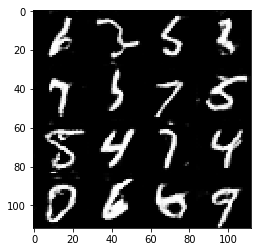

Epoch 2/2... Discriminator Loss: 0.7675... Generator Loss: 1.3682
Epoch 2/2... Discriminator Loss: 0.8300... Generator Loss: 1.1948
Epoch 2/2... Discriminator Loss: 0.7286... Generator Loss: 2.8363
Epoch 2/2... Discriminator Loss: 1.9238... Generator Loss: 4.6079
Epoch 2/2... Discriminator Loss: 1.4968... Generator Loss: 0.6038
Epoch 2/2... Discriminator Loss: 0.6265... Generator Loss: 1.9373
Epoch 2/2... Discriminator Loss: 1.8093... Generator Loss: 0.4547


In [21]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


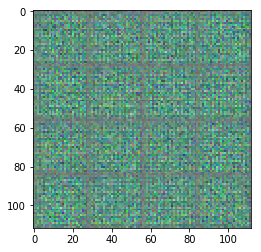

Epoch 1/1... Discriminator Loss: 0.4191... Generator Loss: 4.4279
Epoch 1/1... Discriminator Loss: 0.4122... Generator Loss: 5.9186
Epoch 1/1... Discriminator Loss: 0.4411... Generator Loss: 4.2651
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 8.8570... Generator Loss: 21.5783
Epoch 1/1... Discriminator Loss: 0.4478... Generator Loss: 2.8512
Epoch 1/1... Discriminator Loss: 0.6801... Generator Loss: 4.7613
Epoch 1/1... Discriminator Loss: 0.6999... Generator Loss: 1.5935
Epoch 1/1... Discriminator Loss: 0.6030... Generator Loss: 1.8868
Epoch 1/1... Discriminator Loss: 0.4352... Generator Loss: 3.2713


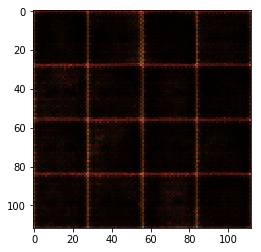

Epoch 1/1... Discriminator Loss: 0.4519... Generator Loss: 2.6474
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 6.8404
Epoch 1/1... Discriminator Loss: 0.5455... Generator Loss: 2.3380
Epoch 1/1... Discriminator Loss: 0.4260... Generator Loss: 3.3302
Epoch 1/1... Discriminator Loss: 1.9992... Generator Loss: 10.6307
Epoch 1/1... Discriminator Loss: 0.4054... Generator Loss: 3.8783
Epoch 1/1... Discriminator Loss: 0.3990... Generator Loss: 3.3103
Epoch 1/1... Discriminator Loss: 0.3806... Generator Loss: 3.4025
Epoch 1/1... Discriminator Loss: 0.5450... Generator Loss: 2.2881
Epoch 1/1... Discriminator Loss: 1.7245... Generator Loss: 0.5863


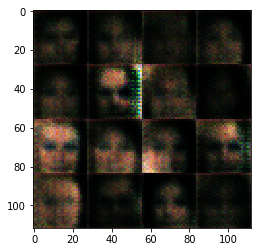

Epoch 1/1... Discriminator Loss: 0.3801... Generator Loss: 4.3896
Epoch 1/1... Discriminator Loss: 0.5706... Generator Loss: 5.0394
Epoch 1/1... Discriminator Loss: 0.4024... Generator Loss: 3.8277
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 2.4399
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 1.7927
Epoch 1/1... Discriminator Loss: 0.6475... Generator Loss: 2.1410
Epoch 1/1... Discriminator Loss: 0.6087... Generator Loss: 2.2595
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 1.1719
Epoch 1/1... Discriminator Loss: 1.5437... Generator Loss: 0.5372
Epoch 1/1... Discriminator Loss: 0.5866... Generator Loss: 1.9550


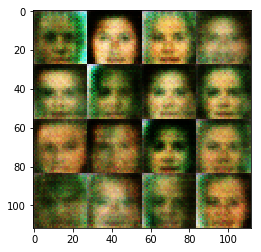

Epoch 1/1... Discriminator Loss: 0.5202... Generator Loss: 2.1341
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 0.5636... Generator Loss: 2.1168
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 7.6754
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 1.0954
Epoch 1/1... Discriminator Loss: 0.4619... Generator Loss: 3.4468
Epoch 1/1... Discriminator Loss: 0.4049... Generator Loss: 4.1024
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 0.8490
Epoch 1/1... Discriminator Loss: 0.3912... Generator Loss: 4.2017


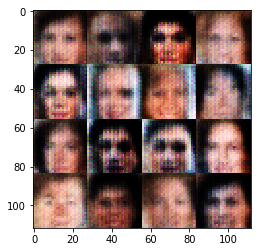

Epoch 1/1... Discriminator Loss: 0.6434... Generator Loss: 5.8610
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 1.0374
Epoch 1/1... Discriminator Loss: 0.5022... Generator Loss: 2.4828
Epoch 1/1... Discriminator Loss: 0.6466... Generator Loss: 2.9076
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 0.7119... Generator Loss: 1.6173
Epoch 1/1... Discriminator Loss: 0.6920... Generator Loss: 1.8048
Epoch 1/1... Discriminator Loss: 0.5485... Generator Loss: 1.9649
Epoch 1/1... Discriminator Loss: 0.7945... Generator Loss: 8.4973
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 4.6131


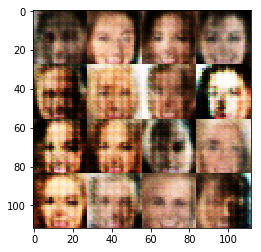

Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 1.3710
Epoch 1/1... Discriminator Loss: 0.5136... Generator Loss: 2.2585
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 7.1806
Epoch 1/1... Discriminator Loss: 0.5619... Generator Loss: 2.1642
Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 1.1018
Epoch 1/1... Discriminator Loss: 0.7012... Generator Loss: 3.7291
Epoch 1/1... Discriminator Loss: 0.6032... Generator Loss: 2.6021
Epoch 1/1... Discriminator Loss: 0.6614... Generator Loss: 7.6157
Epoch 1/1... Discriminator Loss: 0.4202... Generator Loss: 3.4737
Epoch 1/1... Discriminator Loss: 0.7736... Generator Loss: 1.4557


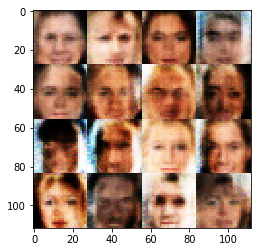

Epoch 1/1... Discriminator Loss: 0.7118... Generator Loss: 2.7786
Epoch 1/1... Discriminator Loss: 0.7215... Generator Loss: 1.4628
Epoch 1/1... Discriminator Loss: 0.7011... Generator Loss: 1.5316
Epoch 1/1... Discriminator Loss: 0.3667... Generator Loss: 4.7431
Epoch 1/1... Discriminator Loss: 0.7524... Generator Loss: 1.5613
Epoch 1/1... Discriminator Loss: 0.7836... Generator Loss: 1.3999
Epoch 1/1... Discriminator Loss: 0.3927... Generator Loss: 4.9100
Epoch 1/1... Discriminator Loss: 0.4058... Generator Loss: 3.2961
Epoch 1/1... Discriminator Loss: 0.5427... Generator Loss: 1.9540
Epoch 1/1... Discriminator Loss: 0.5133... Generator Loss: 2.1755


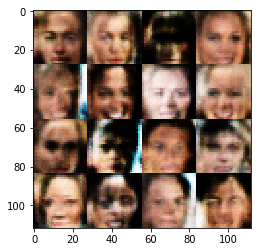

Epoch 1/1... Discriminator Loss: 0.4003... Generator Loss: 3.3073
Epoch 1/1... Discriminator Loss: 0.6802... Generator Loss: 1.4725
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 0.6695... Generator Loss: 1.9277
Epoch 1/1... Discriminator Loss: 0.5564... Generator Loss: 2.1615
Epoch 1/1... Discriminator Loss: 0.3746... Generator Loss: 5.0484
Epoch 1/1... Discriminator Loss: 0.8033... Generator Loss: 1.2454
Epoch 1/1... Discriminator Loss: 0.3542... Generator Loss: 5.2390
Epoch 1/1... Discriminator Loss: 0.4149... Generator Loss: 3.5273
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.9095


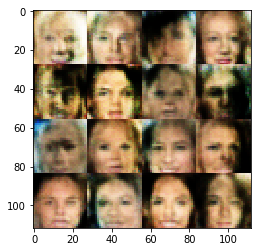

Epoch 1/1... Discriminator Loss: 0.7724... Generator Loss: 1.2654
Epoch 1/1... Discriminator Loss: 0.4536... Generator Loss: 2.5233
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 5.4560
Epoch 1/1... Discriminator Loss: 0.4081... Generator Loss: 3.6176
Epoch 1/1... Discriminator Loss: 1.5584... Generator Loss: 0.4321
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.5768
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 5.8068
Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 1.1152
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 0.3723... Generator Loss: 5.9336


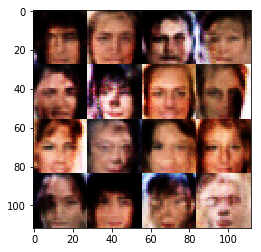

Epoch 1/1... Discriminator Loss: 0.4735... Generator Loss: 5.8316
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 4.4951
Epoch 1/1... Discriminator Loss: 0.5955... Generator Loss: 4.2427
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 0.8862... Generator Loss: 1.0464
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 2.7387
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 0.6791... Generator Loss: 7.5438
Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 1.0011


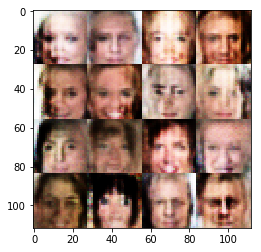

Epoch 1/1... Discriminator Loss: 0.3805... Generator Loss: 4.1817
Epoch 1/1... Discriminator Loss: 1.6709... Generator Loss: 6.3572
Epoch 1/1... Discriminator Loss: 0.4031... Generator Loss: 3.8900
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 5.6015
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 0.7462... Generator Loss: 1.2837
Epoch 1/1... Discriminator Loss: 0.6709... Generator Loss: 1.5525
Epoch 1/1... Discriminator Loss: 0.5219... Generator Loss: 2.7080
Epoch 1/1... Discriminator Loss: 0.4493... Generator Loss: 3.9822
Epoch 1/1... Discriminator Loss: 0.3911... Generator Loss: 3.4021


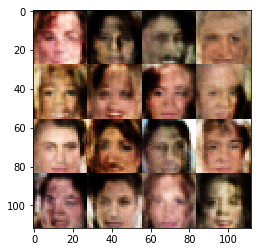

Epoch 1/1... Discriminator Loss: 0.3546... Generator Loss: 6.7725
Epoch 1/1... Discriminator Loss: 0.4612... Generator Loss: 2.6262
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 0.9812
Epoch 1/1... Discriminator Loss: 0.5684... Generator Loss: 2.1662
Epoch 1/1... Discriminator Loss: 0.5840... Generator Loss: 3.3863
Epoch 1/1... Discriminator Loss: 0.4619... Generator Loss: 2.6387
Epoch 1/1... Discriminator Loss: 0.5223... Generator Loss: 2.2294
Epoch 1/1... Discriminator Loss: 0.5481... Generator Loss: 2.1062
Epoch 1/1... Discriminator Loss: 0.5199... Generator Loss: 2.5038
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 0.9577


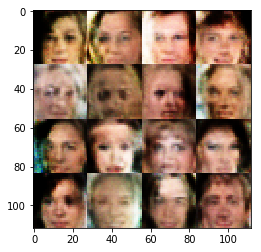

Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.1756
Epoch 1/1... Discriminator Loss: 0.6263... Generator Loss: 1.8589
Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 1.0576
Epoch 1/1... Discriminator Loss: 0.6643... Generator Loss: 1.5970
Epoch 1/1... Discriminator Loss: 0.4585... Generator Loss: 2.7178
Epoch 1/1... Discriminator Loss: 0.8314... Generator Loss: 1.2341
Epoch 1/1... Discriminator Loss: 0.3941... Generator Loss: 3.5845
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 4.8729
Epoch 1/1... Discriminator Loss: 0.4936... Generator Loss: 2.5153
Epoch 1/1... Discriminator Loss: 0.3951... Generator Loss: 3.3631


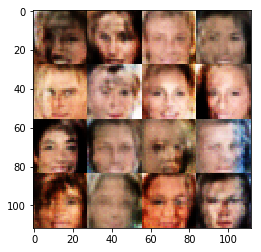

Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 0.3598... Generator Loss: 4.2258
Epoch 1/1... Discriminator Loss: 0.3851... Generator Loss: 3.8144
Epoch 1/1... Discriminator Loss: 0.3667... Generator Loss: 4.3763
Epoch 1/1... Discriminator Loss: 0.3630... Generator Loss: 4.0110
Epoch 1/1... Discriminator Loss: 0.6374... Generator Loss: 1.7739
Epoch 1/1... Discriminator Loss: 0.7259... Generator Loss: 1.8767
Epoch 1/1... Discriminator Loss: 0.5446... Generator Loss: 2.1024
Epoch 1/1... Discriminator Loss: 0.3938... Generator Loss: 3.5522
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 5.2004


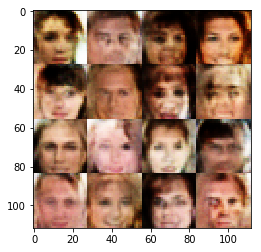

Epoch 1/1... Discriminator Loss: 0.4272... Generator Loss: 5.0614
Epoch 1/1... Discriminator Loss: 0.3737... Generator Loss: 3.7599
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 0.6164... Generator Loss: 2.6634
Epoch 1/1... Discriminator Loss: 0.5233... Generator Loss: 2.0951
Epoch 1/1... Discriminator Loss: 0.6479... Generator Loss: 1.8806
Epoch 1/1... Discriminator Loss: 0.6543... Generator Loss: 1.4653
Epoch 1/1... Discriminator Loss: 0.7083... Generator Loss: 4.4278
Epoch 1/1... Discriminator Loss: 0.4402... Generator Loss: 3.1929
Epoch 1/1... Discriminator Loss: 0.5657... Generator Loss: 1.8754


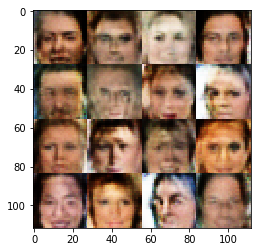

Epoch 1/1... Discriminator Loss: 0.4464... Generator Loss: 2.7091
Epoch 1/1... Discriminator Loss: 0.4466... Generator Loss: 3.7781
Epoch 1/1... Discriminator Loss: 0.4528... Generator Loss: 3.1181
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 1.1885
Epoch 1/1... Discriminator Loss: 0.5593... Generator Loss: 1.8913
Epoch 1/1... Discriminator Loss: 0.6338... Generator Loss: 1.9234
Epoch 1/1... Discriminator Loss: 0.6572... Generator Loss: 6.7437
Epoch 1/1... Discriminator Loss: 0.7866... Generator Loss: 1.3341
Epoch 1/1... Discriminator Loss: 0.7493... Generator Loss: 2.0509
Epoch 1/1... Discriminator Loss: 0.4188... Generator Loss: 3.1140


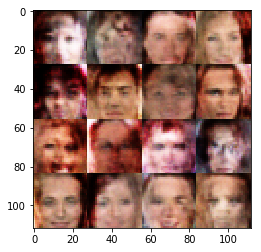

Epoch 1/1... Discriminator Loss: 0.5413... Generator Loss: 2.0293
Epoch 1/1... Discriminator Loss: 0.4624... Generator Loss: 2.9002
Epoch 1/1... Discriminator Loss: 0.4803... Generator Loss: 2.6525
Epoch 1/1... Discriminator Loss: 0.4829... Generator Loss: 2.3203
Epoch 1/1... Discriminator Loss: 0.4412... Generator Loss: 2.6879
Epoch 1/1... Discriminator Loss: 0.4376... Generator Loss: 3.0978
Epoch 1/1... Discriminator Loss: 0.3831... Generator Loss: 3.6848
Epoch 1/1... Discriminator Loss: 0.4814... Generator Loss: 2.4254
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 0.4074... Generator Loss: 3.1936


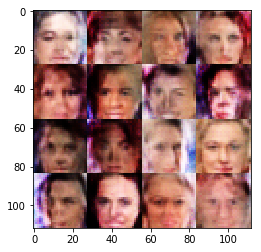

Epoch 1/1... Discriminator Loss: 2.0351... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 0.6230... Generator Loss: 3.0237
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 0.6312... Generator Loss: 1.9233
Epoch 1/1... Discriminator Loss: 1.6914... Generator Loss: 0.3855
Epoch 1/1... Discriminator Loss: 0.7673... Generator Loss: 1.2490
Epoch 1/1... Discriminator Loss: 0.6535... Generator Loss: 1.5794
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 3.7313
Epoch 1/1... Discriminator Loss: 0.7090... Generator Loss: 1.5248
Epoch 1/1... Discriminator Loss: 0.6668... Generator Loss: 1.5603


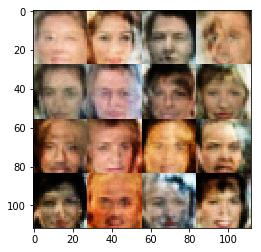

Epoch 1/1... Discriminator Loss: 0.5548... Generator Loss: 1.8366
Epoch 1/1... Discriminator Loss: 0.6564... Generator Loss: 1.4562
Epoch 1/1... Discriminator Loss: 0.4036... Generator Loss: 3.9176
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 0.7222... Generator Loss: 1.3891
Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 1.1884
Epoch 1/1... Discriminator Loss: 0.5829... Generator Loss: 2.1153
Epoch 1/1... Discriminator Loss: 0.7184... Generator Loss: 1.3969
Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 1.1525
Epoch 1/1... Discriminator Loss: 0.6898... Generator Loss: 1.4809


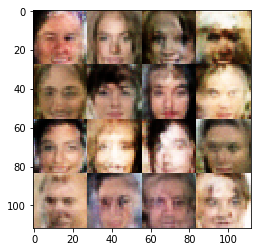

Epoch 1/1... Discriminator Loss: 0.6823... Generator Loss: 1.4165
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.0191
Epoch 1/1... Discriminator Loss: 0.5228... Generator Loss: 2.4878
Epoch 1/1... Discriminator Loss: 1.8176... Generator Loss: 0.3946
Epoch 1/1... Discriminator Loss: 0.6831... Generator Loss: 1.6101
Epoch 1/1... Discriminator Loss: 0.6569... Generator Loss: 1.4944
Epoch 1/1... Discriminator Loss: 0.4579... Generator Loss: 2.5787
Epoch 1/1... Discriminator Loss: 0.4621... Generator Loss: 2.6347
Epoch 1/1... Discriminator Loss: 0.4662... Generator Loss: 2.4520
Epoch 1/1... Discriminator Loss: 0.7821... Generator Loss: 1.3944


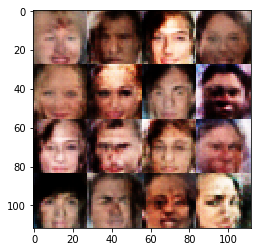

Epoch 1/1... Discriminator Loss: 0.6048... Generator Loss: 1.8643
Epoch 1/1... Discriminator Loss: 0.5220... Generator Loss: 2.1799
Epoch 1/1... Discriminator Loss: 0.4087... Generator Loss: 3.3291
Epoch 1/1... Discriminator Loss: 0.4813... Generator Loss: 2.5009
Epoch 1/1... Discriminator Loss: 0.6778... Generator Loss: 1.5072
Epoch 1/1... Discriminator Loss: 0.3729... Generator Loss: 3.8715
Epoch 1/1... Discriminator Loss: 0.4899... Generator Loss: 2.4205
Epoch 1/1... Discriminator Loss: 0.6383... Generator Loss: 2.6339
Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 1.0051
Epoch 1/1... Discriminator Loss: 0.6479... Generator Loss: 1.9273


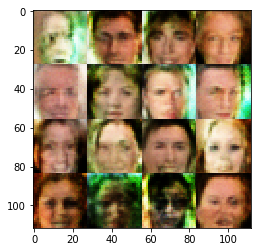

Epoch 1/1... Discriminator Loss: 0.4330... Generator Loss: 2.9462
Epoch 1/1... Discriminator Loss: 0.4360... Generator Loss: 3.0279
Epoch 1/1... Discriminator Loss: 0.4889... Generator Loss: 2.4752
Epoch 1/1... Discriminator Loss: 0.4580... Generator Loss: 2.4583
Epoch 1/1... Discriminator Loss: 0.6020... Generator Loss: 1.7973
Epoch 1/1... Discriminator Loss: 0.4874... Generator Loss: 2.1893
Epoch 1/1... Discriminator Loss: 0.4235... Generator Loss: 3.0960
Epoch 1/1... Discriminator Loss: 1.6814... Generator Loss: 4.6837
Epoch 1/1... Discriminator Loss: 0.3510... Generator Loss: 5.7376
Epoch 1/1... Discriminator Loss: 0.4678... Generator Loss: 2.3263


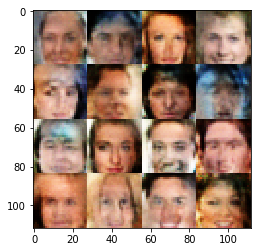

Epoch 1/1... Discriminator Loss: 1.9511... Generator Loss: 0.4145
Epoch 1/1... Discriminator Loss: 0.4674... Generator Loss: 2.5197
Epoch 1/1... Discriminator Loss: 0.8745... Generator Loss: 1.0790
Epoch 1/1... Discriminator Loss: 0.3887... Generator Loss: 3.4673
Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 1.0302
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 3.2806
Epoch 1/1... Discriminator Loss: 0.7178... Generator Loss: 4.2477
Epoch 1/1... Discriminator Loss: 0.8257... Generator Loss: 3.6993
Epoch 1/1... Discriminator Loss: 0.6712... Generator Loss: 1.8685
Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 0.9650


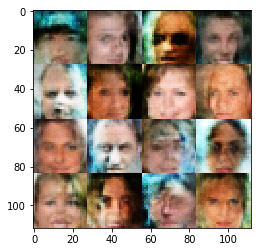

Epoch 1/1... Discriminator Loss: 0.5778... Generator Loss: 1.8555
Epoch 1/1... Discriminator Loss: 0.5274... Generator Loss: 2.1111
Epoch 1/1... Discriminator Loss: 0.4418... Generator Loss: 2.6728
Epoch 1/1... Discriminator Loss: 0.4402... Generator Loss: 2.5835
Epoch 1/1... Discriminator Loss: 0.5535... Generator Loss: 1.8435
Epoch 1/1... Discriminator Loss: 0.4972... Generator Loss: 2.6928
Epoch 1/1... Discriminator Loss: 0.3749... Generator Loss: 3.9443
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 2.5068
Epoch 1/1... Discriminator Loss: 0.4835... Generator Loss: 2.6475
Epoch 1/1... Discriminator Loss: 0.6045... Generator Loss: 1.9920


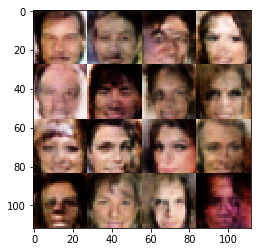

Epoch 1/1... Discriminator Loss: 0.6637... Generator Loss: 1.5237
Epoch 1/1... Discriminator Loss: 0.6243... Generator Loss: 1.9938
Epoch 1/1... Discriminator Loss: 0.6036... Generator Loss: 1.6685
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 0.5068... Generator Loss: 2.4868
Epoch 1/1... Discriminator Loss: 0.4109... Generator Loss: 3.9348
Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 1.2246
Epoch 1/1... Discriminator Loss: 0.3787... Generator Loss: 3.6818
Epoch 1/1... Discriminator Loss: 0.4998... Generator Loss: 2.2017
Epoch 1/1... Discriminator Loss: 0.5971... Generator Loss: 2.6248


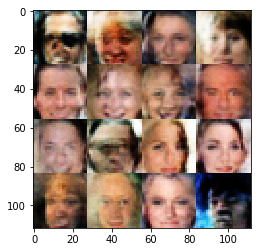

Epoch 1/1... Discriminator Loss: 0.5280... Generator Loss: 2.0304
Epoch 1/1... Discriminator Loss: 0.4011... Generator Loss: 5.7963
Epoch 1/1... Discriminator Loss: 0.4519... Generator Loss: 3.0127
Epoch 1/1... Discriminator Loss: 0.3858... Generator Loss: 4.1310
Epoch 1/1... Discriminator Loss: 0.4982... Generator Loss: 4.3414
Epoch 1/1... Discriminator Loss: 0.4199... Generator Loss: 3.0721
Epoch 1/1... Discriminator Loss: 0.3925... Generator Loss: 3.5903
Epoch 1/1... Discriminator Loss: 0.4645... Generator Loss: 2.8599
Epoch 1/1... Discriminator Loss: 0.5934... Generator Loss: 2.4360
Epoch 1/1... Discriminator Loss: 0.6305... Generator Loss: 1.8725


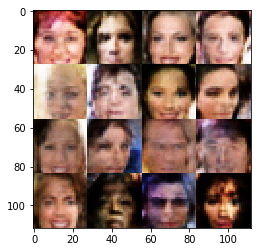

Epoch 1/1... Discriminator Loss: 0.6935... Generator Loss: 3.2342
Epoch 1/1... Discriminator Loss: 1.5066... Generator Loss: 0.5201
Epoch 1/1... Discriminator Loss: 0.4328... Generator Loss: 3.2709
Epoch 1/1... Discriminator Loss: 0.3975... Generator Loss: 3.9184
Epoch 1/1... Discriminator Loss: 0.7068... Generator Loss: 1.4745
Epoch 1/1... Discriminator Loss: 0.3683... Generator Loss: 4.0623
Epoch 1/1... Discriminator Loss: 0.5851... Generator Loss: 1.9482
Epoch 1/1... Discriminator Loss: 0.3689... Generator Loss: 3.8640
Epoch 1/1... Discriminator Loss: 0.3753... Generator Loss: 3.7987
Epoch 1/1... Discriminator Loss: 2.0631... Generator Loss: 4.6500


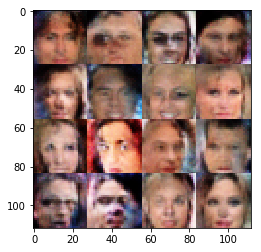

Epoch 1/1... Discriminator Loss: 0.5907... Generator Loss: 1.7867
Epoch 1/1... Discriminator Loss: 0.6035... Generator Loss: 1.6793
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 0.4963... Generator Loss: 4.1191
Epoch 1/1... Discriminator Loss: 0.5492... Generator Loss: 1.9724
Epoch 1/1... Discriminator Loss: 0.3836... Generator Loss: 4.1219
Epoch 1/1... Discriminator Loss: 0.6537... Generator Loss: 3.2793
Epoch 1/1... Discriminator Loss: 0.5853... Generator Loss: 2.0250
Epoch 1/1... Discriminator Loss: 0.3546... Generator Loss: 5.7025
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 2.8545


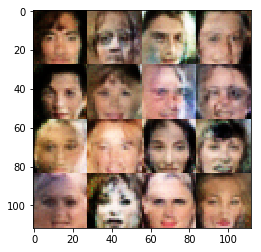

Epoch 1/1... Discriminator Loss: 0.6119... Generator Loss: 1.8125
Epoch 1/1... Discriminator Loss: 0.3964... Generator Loss: 5.5022
Epoch 1/1... Discriminator Loss: 0.5813... Generator Loss: 1.7624
Epoch 1/1... Discriminator Loss: 0.6072... Generator Loss: 1.7321
Epoch 1/1... Discriminator Loss: 0.4042... Generator Loss: 3.2628
Epoch 1/1... Discriminator Loss: 0.6133... Generator Loss: 1.7370
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 6.4545
Epoch 1/1... Discriminator Loss: 0.3772... Generator Loss: 4.0391
Epoch 1/1... Discriminator Loss: 0.6337... Generator Loss: 1.6614
Epoch 1/1... Discriminator Loss: 0.3955... Generator Loss: 3.2106


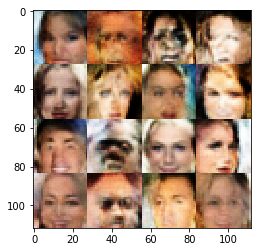

Epoch 1/1... Discriminator Loss: 0.4255... Generator Loss: 2.9868
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 2.7776
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 0.7583... Generator Loss: 1.2696
Epoch 1/1... Discriminator Loss: 0.6952... Generator Loss: 1.5270
Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 1.4804
Epoch 1/1... Discriminator Loss: 0.7924... Generator Loss: 1.3893
Epoch 1/1... Discriminator Loss: 0.4281... Generator Loss: 3.0049
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 3.7404
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 1.0478


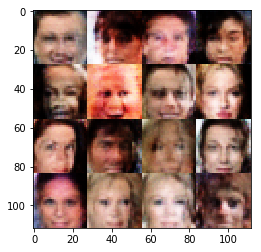

Epoch 1/1... Discriminator Loss: 0.6416... Generator Loss: 1.6213
Epoch 1/1... Discriminator Loss: 0.3992... Generator Loss: 5.8700
Epoch 1/1... Discriminator Loss: 0.5357... Generator Loss: 1.9925
Epoch 1/1... Discriminator Loss: 0.3723... Generator Loss: 4.3193
Epoch 1/1... Discriminator Loss: 0.3799... Generator Loss: 4.0955
Epoch 1/1... Discriminator Loss: 0.4366... Generator Loss: 2.8898
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 0.5604... Generator Loss: 2.7771
Epoch 1/1... Discriminator Loss: 0.4075... Generator Loss: 2.8875
Epoch 1/1... Discriminator Loss: 0.3791... Generator Loss: 4.9329


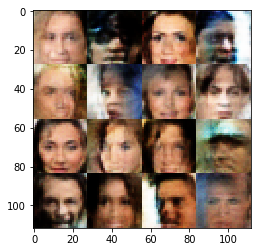

Epoch 1/1... Discriminator Loss: 0.3702... Generator Loss: 4.3968
Epoch 1/1... Discriminator Loss: 0.5469... Generator Loss: 2.0405
Epoch 1/1... Discriminator Loss: 0.4240... Generator Loss: 3.7280
Epoch 1/1... Discriminator Loss: 0.4278... Generator Loss: 3.2437
Epoch 1/1... Discriminator Loss: 0.4061... Generator Loss: 2.9602
Epoch 1/1... Discriminator Loss: 1.8380... Generator Loss: 6.2602


In [22]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.